<a href="https://colab.research.google.com/github/mraj2018/AIML/blob/master/Deep_Learning_R7_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of the project is to learn how to implement a simple image classification
pipeline based on the k-Nearest Neighbour and a deep neural network. The goals of this
assignment are as follows:


● Understand the basic Image Classification pipeline and the data-driven
approach (train/predict stages)

● Data fetching and understand the train/val/test splits.

● Implement and apply an optimal k-Nearest Neighbor (kNN) classifier (7.5
points)

● Print the classification metric report (2.5 points)

● Implement and apply a deep neural network classifier including (feedforward
neural network, RELU activations) (5 points)

● Understand and be able to implement (vectorized) backpropagation (cost
stochastic gradient descent, cross entropy loss, cost functions) (2.5 points)

● Implement batch normalization for training the neural network (2.5 points)● Understand the differences and trade-offs between traditional and NN
classifiers with the help of classification metrics (5 points)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from __future__ import print_function
import keras
import keras.optimizers as opt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential

##############################
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import datasets
from skimage import exposure
import numpy as np
import imutils
import cv2
import sklearn

In [24]:
!ls "/content/drive/My Drive/SVHNN"

filename = '/content/drive/My Drive/SVHNN/SVHN_single_grey1.h5'
root_dir = '/content/drive/My Drive/'


SVHN_single_grey1.h5


In [25]:
f = h5py.File(filename, 'r')
print(list(f.keys()))

img_train = f[u'X_train']
img_test = f[u'X_test']
img_val = f[u'X_val']

lbl_train = f[u'y_train']
lbl_test = f[u'y_test']
lbl_val = f[u'y_val']

img_train.shape,img_test.shape,img_val.shape, lbl_train.shape,lbl_test.shape

['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']


((42000, 32, 32), (18000, 32, 32), (60000, 32, 32), (42000,), (18000,))

In [26]:
# retrieve the train ,test images and reshape them.

x_train = np.array(img_train)
x_test = np.array(img_test)
x_val=np.array(img_val)

#reshape data to fit model
x_train = x_train.reshape(42000,32,32,1)
x_test = x_test.reshape(18000,32,32,1)
x_val=x_val.reshape(60000,32,32,1)

print(x_test.shape)
print(x_train.shape)

(18000, 32, 32, 1)
(42000, 32, 32, 1)


In [0]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

6


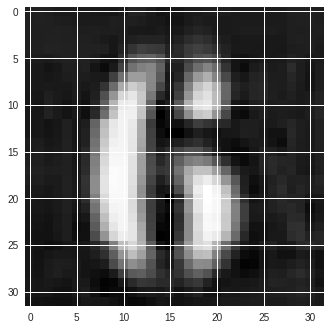

In [29]:
# Check images and labels for their correctness
print(lbl_train[1000])
plt.imshow(x_train[1000].reshape(32,32));

In [39]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(lbl_train, 10)
y_test = keras.utils.to_categorical(lbl_test, 10)

print(y_train.shape,y_test.shape)

(42000, 10) (18000, 10)


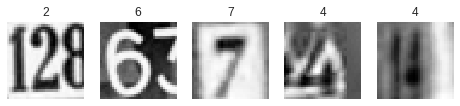

In [31]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])
        
plot_images(x_train, lbl_train, 1, 5)

In [33]:
# normalize the data

train_mean = np.mean(x_train, axis=0) #Shape (32,1)
train_std = np.std(x_train, axis=0) #Shape (32,1)
x_train_norm = (x_train - train_mean) / train_std
x_train_255 = np.divide(x_train, 255)
x_train_255 = np.array(x_train_255)

x_test_255 = np.divide(x_test, 255)
x_test_255 = np.array(x_test_255)

print("X_train_norm Shape: ", x_train_norm.shape)
print("X_train_255 Shape: ", x_train_255.shape)
print("X_test_255 Shape: ", x_test_255.shape)

X_train_norm Shape:  (42000, 32, 32, 1)
X_train_255 Shape:  (42000, 32, 32, 1)
X_test_255 Shape:  (18000, 32, 32, 1)


In [34]:
# Convert 3d images into 2d 
nsamples, nx, ny, gsc = x_train.shape
msamples,mx,my,mgsc = x_test.shape
xtrain = x_train.reshape((nsamples,nx*ny))
xtest = x_test.reshape((msamples,mx*my))

print("Xtrain 32*32: ", xtrain.shape)
print("Xtest32*32: ", xtest.shape)



Xtrain 32*32:  (42000, 1024)
Xtest32*32:  (18000, 1024)


In [11]:
#KNN expects 2d num arrays for the training dataset for a fit function.we need to reshape the array into a 2d. 
#Lets first try with original image resolution of 32*32

# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k
kVals = range(1, 30, 2)
accuracies = []


# loop over kVals
for k in range(1, 30, 2):
# train the classifier with the current value of `k`
  model = KNeighborsClassifier(n_neighbors=k ,algorithm='brute',weights='distance')
  model.fit(xtrain, y_train)

    # evaluate the model and print the accuracies list
  score = model.score(xtest, y_test)
  print("k=%d, accuracy=%.2f%%" % (k, score * 100))
  accuracies.append(score)
    
# largest accuracy
# np.argmax returns the indices of the maximum values along an axis
i = np.argmax(accuracies)
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i],accuracies[i] * 100))

k=1, accuracy=45.92%
k=3, accuracy=37.88%
k=5, accuracy=32.44%
k=7, accuracy=28.77%
k=9, accuracy=26.04%
k=11, accuracy=23.69%
k=13, accuracy=21.73%
k=15, accuracy=20.14%
k=17, accuracy=18.74%
k=19, accuracy=17.53%
k=21, accuracy=16.38%
k=23, accuracy=15.39%
k=25, accuracy=14.60%
k=27, accuracy=13.69%
k=29, accuracy=13.14%
k=1 achieved highest accuracy of 45.92% on validation data


In [46]:
# K value 1 gave the high accuracy. Use the 32*32 image source

model = KNeighborsClassifier(n_neighbors=1,algorithm='brute')
model.fit(xtrain, y_train)
predictions = model.predict(xtest)

score = model.score(xtest, y_test)
print("Accuracy=" , (score * 100))
print("EVALUATION ON TESTING DATA")
print(classification_report(y_test, predictions))

Accuracy= 45.92222222222222
EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.47      0.52      0.49      1814
           1       0.50      0.57      0.53      1828
           2       0.54      0.48      0.51      1803
           3       0.37      0.35      0.36      1719
           4       0.60      0.57      0.59      1812
           5       0.38      0.33      0.36      1768
           6       0.38      0.39      0.39      1832
           7       0.63      0.59      0.61      1808
           8       0.34      0.37      0.36      1812
           9       0.39      0.40      0.40      1804

   micro avg       0.46      0.46      0.46     18000
   macro avg       0.46      0.46      0.46     18000
weighted avg       0.46      0.46      0.46     18000
 samples avg       0.46      0.46      0.46     18000



In [0]:
#Implement and apply a deep neural network classifier including (feedforward neural network, RELU activations) (5 points)

In [47]:
from keras.constraints import max_norm
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), strides=1, activation='relu',input_shape=(32, 32, 1), kernel_constraint=max_norm(3)))
model2.add(MaxPooling2D(pool_size=(3, 3), strides=2))
model2.add(Conv2D(64, (3, 3), activation='relu', strides=1, kernel_constraint=max_norm(3)))
model2.add(MaxPooling2D(pool_size=(3, 3), strides=2))
model2.add(Conv2D(128, (3, 3), activation='relu', strides=1, kernel_constraint=max_norm(3)))
model2.add(MaxPooling2D(pool_size=(3, 3), strides=2))
model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dense(10))
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Store Training Results
early_stopping = keras.callbacks.EarlyStopping(monitor='acc', patience=3, verbose=1, mode='auto')
callback_list = [early_stopping]# [stats, early_stopping]



Instructions for updating:
Colocations handled automatically by placer.


In [48]:
model2.fit(x_train_255, y_train,batch_size=32,epochs=10, callbacks=callback_list, verbose=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
42000/42000 [==============================] - 18s 430us/step - loss: 1.2072 - acc: 0.5920
Epoch 2/10
42000/42000 [==============================] - 13s 305us/step - loss: 0.5537 - acc: 0.8355
Epoch 3/10
42000/42000 [==============================] - 13s 306us/step - loss: 0.4231 - acc: 0.8737
Epoch 4/10
42000/42000 [==============================] - 13s 306us/step - loss: 0.3618 - acc: 0.8909
Epoch 5/10
42000/42000 [==============================] - 13s 302us/step - loss: 0.3191 - acc: 0.9048
Epoch 6/10
42000/42000 [==============================] - 13s 304us/step - loss: 0.2907 - acc: 0.9133
Epoch 7/10
42000/42000 [==============================] - 13s 303us/step - loss: 0.2682 - acc: 0.9196
Epoch 8/10
42000/42000 [==============================] - 13s 304us/step - loss: 0.2496 - acc: 0.9241
Epoch 9/10
42000/42000 [==============================] - 13s 305us/step - loss: 0.2312 - acc: 0.9300
Epoch 10/10
42000/42000 [=========

In [49]:
print('Evaluation')
loss, acc = model2.evaluate(x_test_255,y_test,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

Evaluation
18000/18000 [==============================] - 2s 92us/step
Test loss / test accuracy = 0.3393 / 0.9031


In [0]:
#Understand and be able to implement (vectorized) backpropagation (cost stochastic gradient descent, 
#cross entropy loss, cost functions) (2.5 points)

In [50]:
#create model

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

sgd_optimizer = opt.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='acc', patience=5, verbose=1, mode='auto')
callback_list = [early_stopping]# [stats, early_stopping]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [51]:
model.fit(x_train_255, y_train,
              batch_size=32,
              epochs=10,callbacks=callback_list, verbose=True)

Epoch 1/10
42000/42000 [==============================] - 14s 327us/step - loss: 2.3032 - acc: 0.1026
Epoch 2/10
42000/42000 [==============================] - 13s 314us/step - loss: 1.0011 - acc: 0.6707
Epoch 3/10
42000/42000 [==============================] - 13s 317us/step - loss: 0.4485 - acc: 0.8605
Epoch 4/10
42000/42000 [==============================] - 13s 317us/step - loss: 0.3482 - acc: 0.8926
Epoch 5/10
42000/42000 [==============================] - 13s 315us/step - loss: 0.2936 - acc: 0.9109
Epoch 6/10
42000/42000 [==============================] - 13s 316us/step - loss: 0.2490 - acc: 0.9247
Epoch 7/10
42000/42000 [==============================] - 13s 314us/step - loss: 0.2132 - acc: 0.9341
Epoch 8/10
42000/42000 [==============================] - 13s 315us/step - loss: 0.1895 - acc: 0.9413
Epoch 9/10
42000/42000 [==============================] - 13s 315us/step - loss: 0.1670 - acc: 0.9476
Epoch 10/10
42000/42000 [==============================] - 13s 315us/step - loss: 

In [52]:
print('Evaluation')
loss, acc = model.evaluate(x_test_255,y_test,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

Evaluation
18000/18000 [==============================] - 2s 127us/step
Test loss / test accuracy = 0.2909 / 0.9259


In [0]:
#Implement batch normalization for training the neural network (2.5 points)● 


In [0]:
##create model with SGD & Batchnorm


model_sgd = Sequential()
model_sgd.add(Conv2D(32, (3, 3),padding='same',input_shape=x_train.shape[1:]))
model_sgd.add(BatchNormalization())
model_sgd.add(Activation('relu'))

model_sgd.add(Conv2D(64, (5, 5),padding='same'))
model_sgd.add(BatchNormalization())
model_sgd.add(Activation('relu'))
model_sgd.add(MaxPooling2D(pool_size=(2, 2)))
model_sgd.add(Dropout(0.25))

model_sgd.add(Conv2D(64, (3, 3), padding='same'))
model_sgd.add(BatchNormalization())
model_sgd.add(Activation('relu'))


model_sgd.add(Conv2D(64, (3, 3),padding='same'))
model_sgd.add(BatchNormalization())
model_sgd.add(Activation('relu'))


model_sgd.add(MaxPooling2D(pool_size=(2, 2)))
model_sgd.add(Dropout(0.25))

model_sgd.add(Flatten())
model_sgd.add(Dense(512))
model_sgd.add(Activation('relu'))

model_sgd.add(Dense(10))
model_sgd.add(Activation('softmax'))


#Create optimizer with non-default learning rate


sgd_optimizer = opt.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model_sgd.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Store Training Results
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1, mode='auto')
callback_list = [early_stopping]# [stats, early_stopping]

In [54]:
model_sgd.fit(x_train_255, y_train,batch_size=32,epochs=10,validation_data=(x_test_255, y_test), callbacks=callback_list, verbose=True)

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 36s 850us/step - loss: 1.7826 - acc: 0.3937 - val_loss: 0.7534 - val_acc: 0.7590
Epoch 2/10
42000/42000 [==============================] - 35s 829us/step - loss: 0.5312 - acc: 0.8318 - val_loss: 0.4429 - val_acc: 0.8682
Epoch 3/10
42000/42000 [==============================] - 35s 826us/step - loss: 0.3550 - acc: 0.8901 - val_loss: 0.3558 - val_acc: 0.8911
Epoch 4/10
42000/42000 [==============================] - 35s 825us/step - loss: 0.2857 - acc: 0.9127 - val_loss: 0.3220 - val_acc: 0.9018
Epoch 5/10
42000/42000 [==============================] - 35s 826us/step - loss: 0.2431 - acc: 0.9264 - val_loss: 0.2941 - val_acc: 0.9129
Epoch 6/10
42000/42000 [==============================] - 35s 828us/step - loss: 0.2075 - acc: 0.9372 - val_loss: 0.2575 - val_acc: 0.9239
Epoch 7/10
42000/42000 [==============================] - 35s 826us/step - loss: 0.1834 - acc: 0.9447 - val_loss: 0.

Text(124.71000000000001, 0.5, 'true label')

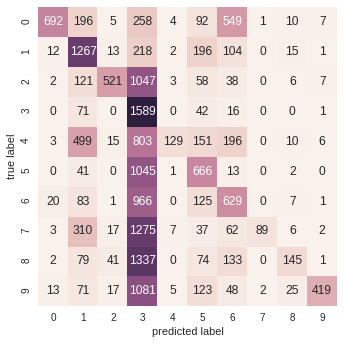

In [55]:
import seaborn as sns
# Predicting the Test set results & Printing the confusion matrix
y_pred = model_sgd.predict(x_test)
y_pred = (y_pred > 0.5)
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

#print(cm)

fig2=plt.figure()
fig2.add_subplot(111)
sns.heatmap(cm,annot=True,square=True,cbar=False,fmt="d")
plt.xlabel("predicted label")
plt.ylabel("true label")

In [0]:
#Understand the differences and trade-offs between traditional and NN classifiers with the help of classification metrics (5 points)

 The observation with Street view images with KNN and NN is as below
 
 1. **KNN was able to predict the images of size (32*32) with 45.92 % accuracy** . KNN captures available cases within the training set and classifies new cases based on a similarity measure (e.g., distance functions). KNN has been used in statistical estimation and traditional pattern recognition algorithm until CNN and deep learning came into existense
 2. ** KNN doesn't learn a discriminative function from the training data but memorizes the training dataset instead**.So everytime you wanted to classify a test set it compares with entire training set which is time consuming and resource constraint.
 3. Whereas ** CNNs can be thought of automatic feature extractors from the image ** . it uses a algorithm with pixel vector and spatial interaction between pixels. **a CNN effectively uses adjacent pixel information to effectively downsample the image first by convolution and then uses a prediction layer at the end** to predict. Hence the accuracy of **Simple NN classifiers started at 90% and went on to increase with backpropagation and batch normalization** .
 